# OpenFermion – SFOpenBoson Tutorials

---

Wayne H Nixalo – 2018/6/27

See [SFOpenBoson docs](https://sfopenboson.readthedocs.io/en/latest/tutorials/gaussian.html) for tutorials.

In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## 1. [Forced quantum harmonic oscillator](https://sfopenboson.readthedocs.io/en/latest/tutorials/gaussian.html)

>Simulating the time-propagation of a Gaussian Hamiltonian using a continuous-variable (CV) quantum circuit is simple with SFOpenBoson. In this tutorial, we will walk through a simple example using the forced quantum harmanic oscillator.

### Background

---

>The Hamiltonian of the forced qauntum harmonic oscillator is given by 

$$\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2}mω^2\hat{q}^2 - F\hat{q}$$

>where
>
>* $m$ is the mass of the oscilllator,
>* $ω$ is the frequency of oscillation,
>* $F$ is a time-independent external force.
>
> Let's define this Hamiltonian using OpenFermion, with $m = ω = 1$ and $F = 2$:

In [1]:
from openfermion.ops import QuadOperator
from openfermion.utils import commutator, normal_ordered

H = QuadOperator('q0 q0', 0.5) + QuadOperator('p0 p0', 0.5) - QuadOperator('q0', 2)

>In the Heisenberg picture, the time-evolution of the $\hat{q}$ and $\hat{p}$ operators is given by:

\begin{split}& \frac{d}{dt}\hat{q} = \frac{i}{\hbar}[\hat{H}, \hat{q}] =  \hat{p}\\
& \frac{d}{dt}\hat{p} = \frac{i}{\hbar}[\hat{H}, \hat{q}] = F-\hat{q}\end{split}

shouldn't that last one be $[\hat{H},\hat{p}]$ ?

>We can double check these using OpenFermion:

In [2]:
(1j/2)*normal_ordered(commutator(H, QuadOperator('q0')), hbar=2)

(1+0j) [p0]

In [3]:
(1j/2)*normal_ordered(commutator(H, QuadOperator('p0')), hbar=2)

(-1+0j) [q0] +
(2+0j) []

>Assuming the oscillator has initial conditions $\hat{q}(0)$ and $\hat{p}(0)$, it's easy to solve this coupled set of linear differentials analytically, giving the parameterized solution:

\begin{split}&\hat{q}(t) = (\hat{q}(0)-F)\cos(t) + \hat{p}(0)\sin(t) + F\\
&\hat{p}(t) = (F-\hat{q}(0))\sin(t) + \hat{p}(0)\cos(t)\end{split}

>Let's now attempt to simulate these dynamics directly in Strawberry Fields, solely from the Hamiltonian we defined above.

### Strawberry Fields simulation

---

>To simulate the time-propagation of the forced oscillator in StrawberryFields, we also need to impmort the `GaussianPropagation` class from the SFOpenBoson plugin:

In [5]:
import strawberryfields as sf
from strawberryfields.ops import *
from sfopenboson.ops import GaussianPropagation

>`GaussianPropagation` accepts the following arguments:
* `operator`: a bosonic Gaussian Hamiltonian, either in the form of a `BosonOperator` or `QuadOperator`.
* `t` (float): the time propagation value. If not provided, default value is 1.
* `mode` (str): By default, `mode='local'` and the Hamiltonian is assumed to apply to only the applied qumodes. For example, if `QuadOperator('q0 p1') | | (q[2], q[4])`, then `q0` acts on `q[2]`, and `p1` acts on `q[4]`.
>
>Alternatively, you can set `mode='global`, and the Hamiltonian is instead applied to the entire register by directly matching qumode numbers of the defined Hamiltonian; ie: `q0` is applied to `q[0[]`, `p1` is applied to `q[1]`, etc.
>
>Let's set up the one qumode quantum circuit, propagating the forced oscillator Hamiltonian `H` we defined in the previous section, starting from the initial location $(1, 0.5)$ in phase space, for time $t = 1.43$:

In [7]:
eng, q = sf.Engine(1)
with eng:
    Xgate(1) | q[0]
    Zgate(0.5) | q[0]
    GaussianPropagation(H, 1.43) | q

>Now, we can run this simulation using the [Gaussian backend of Strawberry Fields](https://strawberryfields.readthedocs.io/en/latest/code/backend.gaussian.html), and output the location of the oscillator in phase space at time $t = 1.43$:

In [8]:
state = eng.run('gaussian')
state.means()

array([2.35472067, 1.06027036])

>We compare this to the analytic solution,

\begin{split}&\langle\hat{q}(1.43)\rangle = (1-2)\cos(1.43) + 0.5\sin(1.43) + 2 = 2.35472,\\
&\langle\hat{p}(1.43)\rangle = (2-1)\sin(1.43) + 0.5\cos(1.43) = 1.06027,\end{split}

> which is in good agreement with the Strawberry Fields result.
>
> We can also print the CV gates applied by the engine, to see how our time-evolution operator $e^{-i\hat{H}t/\hbar}$ got decomposed:

In [9]:
eng.print_applied()

Xgate(1), 	(reg[0])
Zgate(0.5), 	(reg[0])
Rgate(-1.43), 	(reg[0])
Xgate(1.719), 	(reg[0])
Zgate(1.98), 	(reg[0])


### Plotting the phase-space time evolution

---

>By looping over various values of $t$, we can plot the phase space location of the oscillator for various values of $t$.
>
>Consider the following example:

In [10]:
eng, q = sf.Engine(1, hbar=2)

t_vals = np.arange(0, 6, 0.02)
results = np.zeros([2, len(t_vals)])

for step, t in enumerate(t_vals):
    eng.reset()
    with eng:
        Xgate(1) | q[0]
        Zgate(0.5) | q[0]
        GaussianPropagation(H, t) | q
        
    state = eng.run('gaussian')
    results[:, step] = state.means()

>Here, we are looping over the same circuit as above for values of $t$ wihtin the domain $0 ≤ t ≤ 6$, and storing the resulting expectation values $(\langle\hat{q}(t)\rangle, \langle\hat{p}t)\rangle)$ in the array `results`. We can plot this array in the phase space:

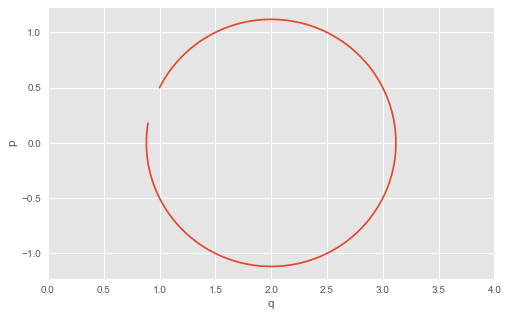

In [40]:
from matplotlib import pyplot as plt

plt.style.use('ggplot')
fig,ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('q'); ax.set_ylabel('p')
plt.xlim((0.0,4.0))
ax.plot(*results);

## 2. [Bose-Hubbard time propagation](https://sfopenboson.readthedocs.io/en/latest/tutorials/bosehubbard.html)

>In this tutorial, we'll walk through an exmaple of Hamiltonian simulation of a Bose-Hubbard model, using Strawberry Fields and OpenFermion.

### On a lattice

---

>OpenFermion provides a convenient Hamiltonian function to automatically generate Bose-Hubbard Hamiltonians on a 2-dimensional lattice. For exmaple, to generate a Bose-Hubbard Hamiltonian on a size $ 1 \times 2$ lattice, with on-site and nearest neighbor interactions, we do

In [42]:
from openfermion.hamiltonians import bose_hubbard

bose_hubbard(x_dimension=1, y_dimension=2, tunneling=1, interaction=2,
             chemical_potential=0., dipole=3., periodic=False)

1.0 [0^ 0 0^ 0] +
-1.0 [0^ 0] +
3.0 [0^ 0 1^ 1] +
-1.0 [0^ 1] +
-1.0 [0 1^] +
1.0 [1^ 1 1^ 1] +
-1.0 [1^ 1]

>For more inofrmation regarding this function, please see the [OpenFermion documentation](http://openfermion.readthedocs.io/en/latest/openfermion.html#openfermion.hamiltonians.bose_hubbard).
>
>Let's use this capability, along with the Hamiltonian propagation and decomposition tools of the SFOpenBoson plugin, to perform Bose-Hubbard simulations in Strawberry Fields. Consider the [Hamiltonian simulation](https://strawberryfields.readthedocs.io/en/latest/algorithms/hamiltonian_simulation.html) algorithm in the Strawberry Fields documentation; to reproduce these results, we first generate a Bose-Hubbard Hamiltonian on a non-periodic $1 \times 2$ lattice, with tunneling coefficient -1, and on-site interaction strength 1.5.

In [43]:
H = bose_hubbard(1, 2, 1, 1.5)

>To simulate the time-propagation of the Hamiltonian in StrawberryFields, we also need to impor the `BoseHubbardPropagation` class from the SFOpenBoson plugin:

In [44]:
import strawberryfields as sf
from strawberryfields.ops import *
from sfopenboson.ops import BoseHubbardPropagation

>`BoseHubbardPropagation` accepts the following arguments:
* `operator`: a Bose-Hubbard Hamiltonian, either in the form of a `BosonOperator` or `QuadOperator`.
* `t` (float): the time propagation value. If not provided, default vaue is 1.
* `k` (int): the number of products in the truncated Lie product formula. Increasing this parameter increases the numerical accuracy of the decomposition, but also increases the depth of the circuit and the computational time.
* `mode` (str): By default, `mode='local'` and the Hamiltonian is assumed to apply to only the applied qumodes. For example, if `QuadOperator('q0 p1') | (q[2], q[4])`, then `q0` acts on `q[2]`, and `p1` acts on `q[4]`.

>Alternatively, you can set `mode='global'`, and the Hamiltonian is instead applied to the entire register by directly matching qumode numbers of the defined Hamiltonian; ie: `q0` is applied to `q[0]`, `p1` is applied to `q[1]`, etc.

>Let's set up the 2 qumode quantum circuit –– each mode corresponds to  a node in the lattice –– and propagating the Bose-Hubbard Hamiltonian `H` we defined in the previous section, starting from the initial state $\big\lvert0,2\big\rangle$ in the Fock space, for time $t = 1.086$ and Lie product truncation $k = 20$:

In [45]:
eng, q = sf.Engine(2)
with eng:
    Fock(2) | q[1]
    BoseHubbardPropagation(H, 1.086, 20) | q

>Now we can run this simulation using the [Fock backend of Strawberry Fields](https://strawberryfields.readthedocs.io/en/latest/code/backend.fock.html), and output the Fock state probabilities at time $t = 1.086$:
>
>**NOTE**
>In the Bose-Hubbard model, the number of particles in the system remains constant, so we do not need to increase the cutoff dimension of the simulation beyond the total number of photons in the initial state.

In [46]:
state = eng.run('fock', cutoff_dim=3)
state.fock_prob([2,0])

0.5224012457200198

In [47]:
state.fock_prob([1,1])

0.2356528768567243

In [48]:
state.fock_prob([0,2])

0.24194587742325954

>We can see that this matches the results obtained in the Strawberry Fields documentation.

>Note that, as in the forced quantum harmonic oscillator, tutorial, we can output the decomposition as applied by the Strawberry Fields engine using `eng.print_applied()`.

### On an arbitrary network

---

>Alternatively, we are not bound to use the `bose_hubbard` function from OpenFermion; we can define our own Bose-Hubbard Hamiltonian using the `BoseOperator` class. For example, consider a Bose-Hubbard model constrained to a 3-vertex cycle graph; that is, the graph formed by connecting 3 vertices to each other in a cycle.

In [49]:
from openfermion.ops import BosonOperator

>Let's define this Hamiltonian using OpenFermion. First, constructing the tunneling terms between each pair of adjacent modes:

In [50]:
J = 1
H = BosonOperator('0 1^', -J) + BosonOperator('0^ 1', -J)
H += BosonOperator('0 2^', -J) + BosonOperator('0^ 2', -J)
H += BosonOperator('1 2^', -J) + BosonOperator('1^ 2', -J)

>Next, let's add an on-site interaction term, with strength $U = 1.5$:

In [51]:
U = 1.5
H += BosonOperator('0^ 0 0^ 0', 0.5*U) - BosonOperator('0^ 0', 0.5*U)
H += BosonOperator('1^ 1 1^ 1', 0.5*U) - BosonOperator('1^ 1', 0.5*U)
H += BosonOperator('2^ 2 2^ 2', 0.5*U) - BosonOperator('2^ 2', 0.5*U)

>**NOTE**
>If a Hamiltonian that cannot be written in the form of a Bose-Hubbard model is passed to a `BoseHubbardPropagation`, a `BoseHubbardError` is returned.

>As before, we use `BoseHubbardPropagation` to simulate this model for time $t = 1.086$, starting from initial state $\big\lvert2,0\big\rangle$. Due to the increased size of this model, let's increase the Lie product truncation to $k = 100$:

In [52]:
eng, q = sf.Engine(3)
with eng:
    Fock(2) | q[0]
    BoseHubbardPropagation(H, 1.086, 100) | q

>Running the circuit, and checking some output probabilities:

In [53]:
state = eng.run('fock', cutoff_dim=3)
for i in ([2,0,0], [1,1,0], [1,0,1], [0,2,0], [0,1,1], [0,0,2]):
    print(state.fock_prob(i))

0.08546707601127217
0.04925517496558026
0.048740564401678614
0.3115175636118121
0.19789100000566362
0.30712862100403837


>To verifiy this result, we can construct the $6\times6$ Hamiltonian matrix $H_{ij} = \langleφ_i\lvert\hat{H}\rvertφ_{ij}\rangle$ is a member of the set of allowed Fock states  $\{∣2,0,0⟩,∣1,1,0⟩,∣1,0,1⟩,∣0,2,0⟩,∣0,1,1⟩,∣0,0,2⟩\}$. Performing these inner products, we find that

\begin{split}H = \begin{bmatrix}
        U & J\sqrt{2} & J\sqrt{2} & 0 & 0 & 0\\
        J\sqrt{2} & 0 & J & J\sqrt{2} & J & 0\\
        J\sqrt{2} & J & 0 & 0 & J & J\sqrt{2}\\
        0 & J\sqrt{2} & 0 & U & J\sqrt{2} & 0\\
        0 & J & J & J\sqrt{2} & 0 & J\sqrt{2}\\
        0 & 0& J\sqrt{2} & 0 & J\sqrt{2} & U
\end{bmatrix}.\end{split}

>Therefore, using SciPy to perform the matrix exponential $e^{iHt}$ applied to the initial state:

In [54]:
from scipy.linalg import expm

Jr2 = J*np.sqrt(2)
H = np.array([[U , Jr2, Jr2, 0  , 0  , 0  ],
             [Jr2, 0  , J  , Jr2, J  , 0  ],
             [Jr2, J  , 0  , 0  , J  , Jr2],
             [0  , Jr2, 0  , U  , Jr2, 0  ],
             [0  , J  , J  , Jr2, 0  , Jr2],
             [0  , 0  , Jr2, 0  , Jr2, U  ]])
np.abs(expm(-1j*H*1.086)[0])**2

array([0.0854745 , 0.04900244, 0.04900244, 0.30932247, 0.19787567,
       0.30932247])

>which agrees within reasonable numerical error with the Strawberry Fields simulation results.